# 卷积神经网络

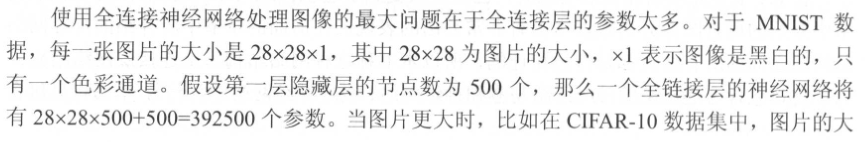

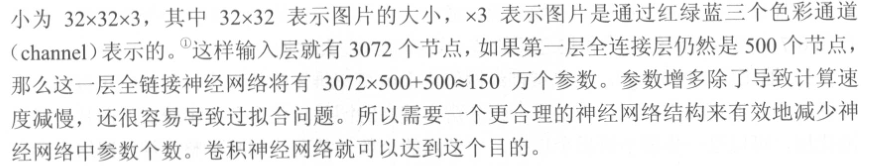

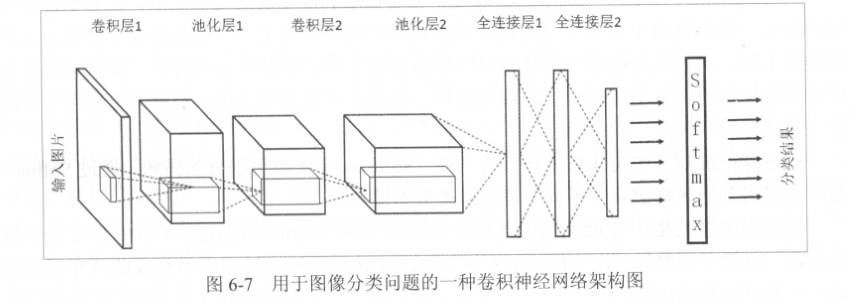

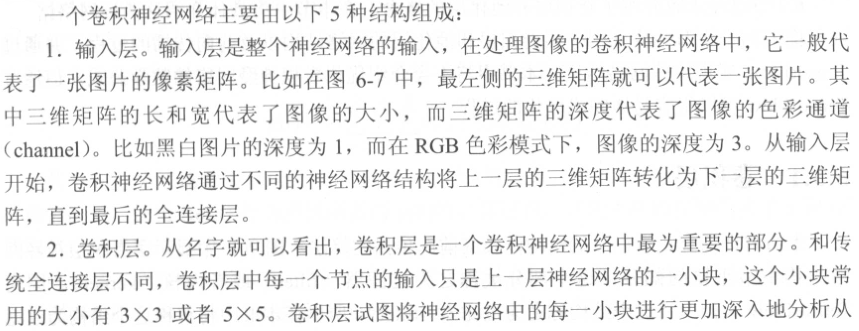

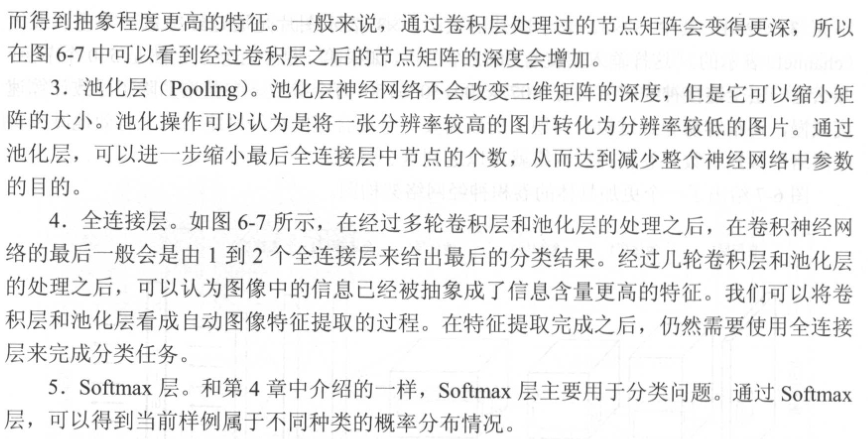

## 卷积层

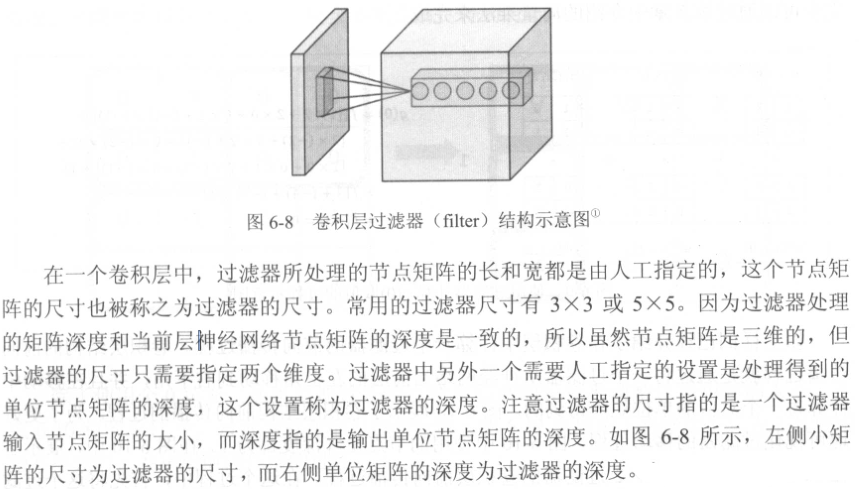

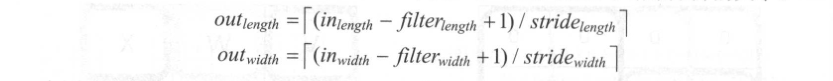
上述公式表示不使用全0填充，输出层矩阵和输入层矩阵大小间的关系（当使用全0填充后，即上和左侧用零补充，其分子仅与输入层矩阵长度有关）

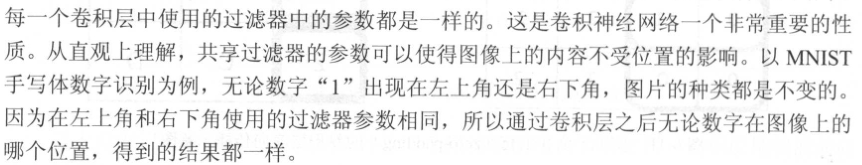

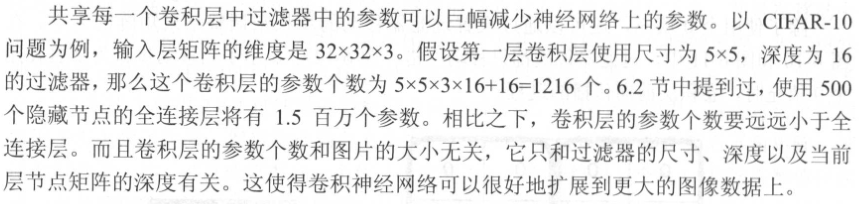

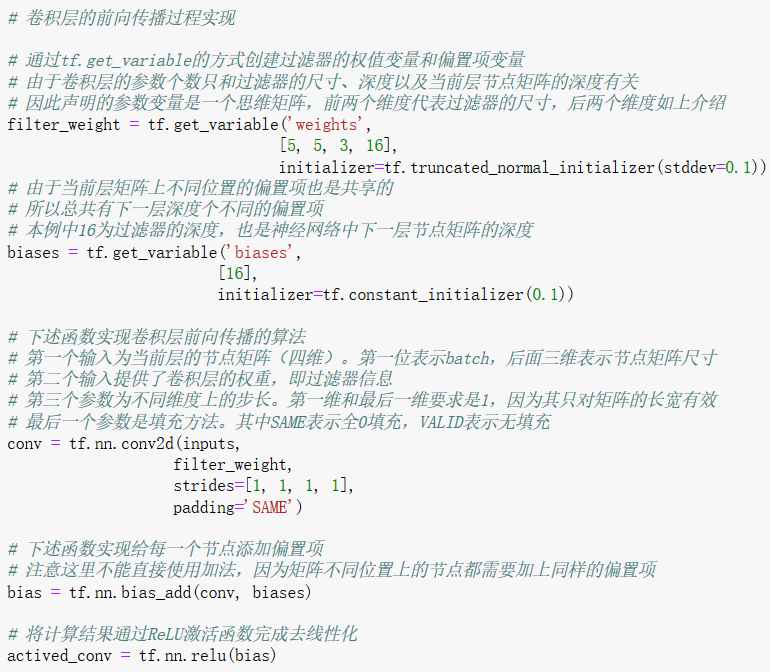

## 池化层

池化层可以非常有效地缩小矩阵的尺寸，从而减少最后全连接层中的参数。使用池化层既可以加快计算速度也有防止过拟合问题的作用。

池化层前向传播的过程也是通过移动一个类似过滤波器的结构完成的，不过过滤器采用更加简单的最大值或者平均值。使用最大值操作的池化层被称之为最大池化层；使用平均值操作的池化层被称之为平均池化层，其他类别使用较少。

卷积层和池化层中过滤器移动的方式是相似的，唯一的区别在于卷积层使用的过滤器是横跨整个深度的，而池化层使用的过滤器只影响一个深度上的节点。所有池化层的过滤器除了在长和宽两个维度移动，它还需要在深度这个维度移动。

最大池化层的前向传播算法
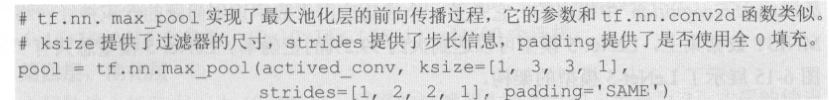

# LeNet-5模型

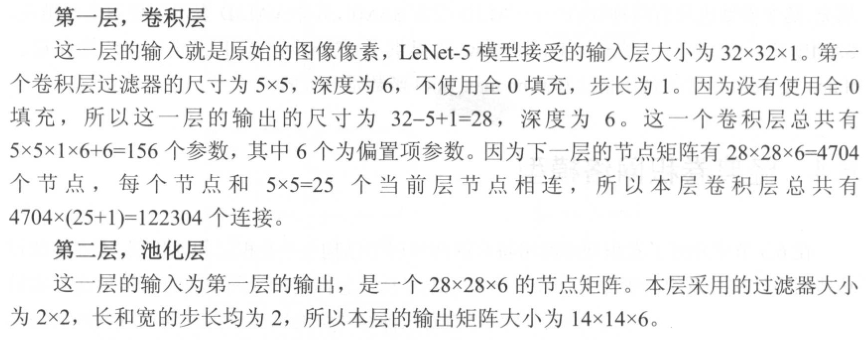

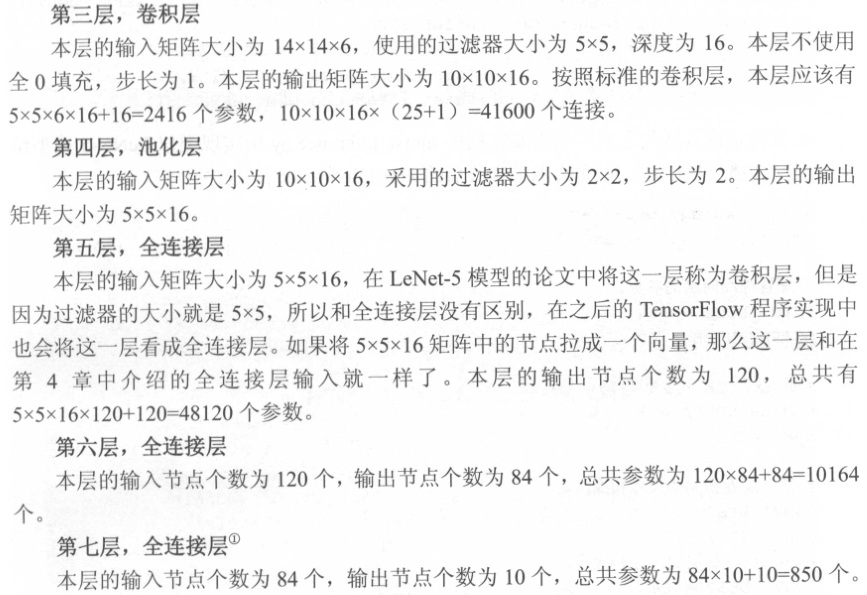

# MNIST卷积网络实现（对上节代码进行删改）

In [4]:
# 定义了前向传播的过程以及神经网络的参数。实际可单独放入一个文件，如mnist_inference.py
# -*- coding: utf-8 -*-
import tensorflow as tf

# 定义神经网络结构相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

#第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5
#第二层卷积层的尺寸和深度
CONV2_DEEP = 64
CONV2_SIZE = 5
# 全连接层的节点个数
FC_SIZE = 512

# 通过tf.get_variable函数来获取变量，在训练神经网络时会创建这些变量
# 在测试时会通过保存的模型加载这些变量的取值
# 因为可以在变量加载时将滑动平均变量重命名
# 所以可以直接通过相同的名字在训练时使用变量自身，而在测试时使用变量的滑动平均值
# 在这个函数中也会将变量的正则化损失加入损失集合
def get_weight_variable(shape, regularizer):
    weights = tf.get_variable('weights',
                              shape,
                             initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    # 当给出了正则化生成函数时，将当前变量的正则化损失加入名字为losses的集合
    # 在这里使用了add_to_collection函数将一个张量加入一个集合
    # 而这个集合的名称为losses，这是自定义集合，不在Tensorflow自动管理的集合列表中
    if regularizer != None:
        tf.add_to_collection('losses', regularizer(weights))
        
    return weights

# 定义卷积神经网络的前向传播过程
# 这里添加了新参数train，用于区分训练过程和测试过程
# 训练中将用到dropout方法，可进一步提升模型可靠性并防止过拟合
def inference(input_tensor, train, regularizer):
    # 声明第一层卷积层的变量并实现前向传播过程
    # 通过使用不同的命名空间来隔离不同层的变量，可让每一层中的变量命名只需要考虑当前层
    # 和标准LeNet-5模型不太一样，这里定义的卷积层输入为28×28×1的原始MNIST图像像素
    # 因为卷积层使用了全0填充，所以输出为28×28×32的矩阵
    with tf.variable_scope('layer1-conv1'):
        conv1_weights = tf.get_variable('weight',
                                       [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
                                       initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv1_biases = tf.get_variable('bias',
                                      [CONV1_DEEP],
                                      initializer=tf.constant_initializer(0.0))
        # 使用边长为5，深度为32的过滤器，过滤器移动的步长为1，且使用全0填充
        conv1 = tf.nn.conv2d(input_tensor,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        
    # 实现第二层池化层的前向传播过程
    # 这里选用最大池化层，过滤器边长为2，使用全0填充且移动步长为2
    # 其输入为28×28×32，输出为14×14×32的矩阵
    with tf.name_scope('layer2-pool1'):
        pool1 = tf.nn.max_pool(relu1,
                              ksize = [1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        
    # 声明第三层卷积层的变量并实现前向传播过程
    # 输入为14×14×32的矩阵，输出为14×14×64的矩阵
    with tf.variable_scope('layer3-conv2'):
        conv2_weights = tf.get_variable('weight',
                                       [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
                                       initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv2_biases = tf.get_variable('bias',
                                      [CONV2_DEEP],
                                      initializer=tf.constant_initializer(0.0))
        # 使用边长为5，深度为64的过滤器，过滤器移动的步长为1，且使用全0填充
        conv2 = tf.nn.conv2d(pool1,
                            conv2_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        
    # 实现第四层池化层的前向传播过程
    # 其输入为14×14×64，输出为7×7×64的矩阵
    with tf.name_scope('layer4-pool2'):
        pool2 = tf.nn.max_pool(relu2,
                              ksize = [1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
    
    # 将第四层池化层的输入转化为第五层全连接层的输入格式
    # 第四层的输入为7×7×64的矩阵，然后第五层全连接层需要输入格式为向量
    # 所以需要将该矩阵拉直成一个向量。get_shape函数可得到第四层输出矩阵的维度
    # 注意每一层神经网络的输入输出都为一个batch的矩阵
    # 所以这里得到的维度也包含一个batch中数据的个数
    pool_shape = pool2.get_shape().as_list()
    # 计算将矩阵拉直成向量之后的长度，这个长度就是矩阵长宽及深度的乘积
    # 注意pool_shape[0]为一个batch中数据的个数
    nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]
    # 将第四层的输出变成一个batch向量
    reshaped = tf.reshape(pool2, [pool_shape[0], nodes])
    
    # 声明第五层全连接层的变量并实现前向传播过程
    # 这层的输入是拉直后的一组长度为3136的向量，输出是一组长度为512的向量
    # 这层和上节基本一致，唯一的区别是引入了dropout概念
    # dropout在训练时会随机将部分节点的输出改为0，避免过拟合问题
    # dropout一般只在全连接层而不是卷积层或池化层使用
    with tf.variable_scope('layer5-fc1'):
        fc1_weights = tf.get_variable('weight',
                                    [nodes, FC_SIZE],
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
        # 只有全连接层的权重需要加入正则化
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable('bias',
                                    [FC_SIZE],
                                    initializer=tf.constant_initializer(0.1))
        
        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        if train:
            fc1 = tf.nn.dropout(fc1, 0.5)
    
    # 声明第六层全连接层的变量并实现前向传播过程
    # 这层的输入是一组长度为512的向量，输出是一组长度为10的向量
    # 这层的输出通过softmax之后就得到了最后的分类结果
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable('weight',
                                    [FC_SIZE, NUM_LABELS],
                                    initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable('bias',
                                    [NUM_LABELS],
                                    initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases
    
    return logit

In [5]:
# 定义了神经网络的训练程序。实际可单独放入一个文件，如mnist_train.py
# -*- coding: utf-8 -*-
import tensorflow as tf
import os
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 加载mnist_inference.py中定义的常量和前向传播的函数（本例是上述程序）
# import mnist_inference

tf.reset_default_graph()

# 配置神经网络的参数
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 20000
MOVING_AVERAGE_DECAY = 0.99

# 模型保存的路径和文件名
MODEL_SAVE_PATH = '/opt/jupyter_files/model-saves/mnist_model/'
MODEL_NAME = 'mnist.ckpt'

def train(mnist):
    # 调整输入数据placeholder的格式，输入为一个四维矩阵
    x = tf.placeholder(tf.float32,
                      [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS],
                      name='x-input')
    y_ = tf.placeholder(tf.float32,
                       [None, OUTPUT_NODE],
                       name='y-input')
    
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 直接使用mnist_inference.py中定义的前向传播过程
    y = inference(x, True, regularizer)
    global_step = tf.Variable(0, trainable=False)
    
    # 定义滑动平均操作、损失函数、学习率以及训练过程
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY,
                                                         global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                  labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    # staircase=True 表示每隔 mnist.train.num_examples / BATCH_SIZE 步对学习率进行一次更新，否则每步更新
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                              global_step,
                                              mnist.train.num_examples / BATCH_SIZE,
                                              LEARNING_RATE_DECAY,
                                              staircase=True)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,
                                                                         global_step)
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')
        
    # 初始化Tensorflow持久化类，max_to_keep参数指定保留多少最新模型信息
    saver = tf.train.Saver(max_to_keep=10)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        # 在训练过程中不再测试模型在验证数据上的表现
        # 验证和测试的过程将会有一个独立的程序来完成
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            xs = np.reshape(xs, (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
            _, loss_value, step = sess.run([train_op, loss, global_step],
                                          feed_dict={x: xs, y_: ys})
            
            # 每1000轮保存一次模型
            if i % 1000 == 0:
                # 输出当前的训练情况，这里只输出了模型在当前训练batch上的损失函数大小
                # 通过损失函数的大小可以大概了解训练的情况
                # 在验证数据集上的正确率信息会有一个单独的程序来生成
                print('After %d training step(s), loss on training batch is %g.'
                      % (step, loss_value))
                #  保存当前模型。注意这里给出了global_step参数
                # 可以让每个被保存模型的文件名末尾加上训练的轮数
                saver.save(sess,
                          os.path.join(MODEL_SAVE_PATH, MODEL_NAME),
                          global_step=global_step)
                
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    train(mnist)
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz
After 1 training step(s), loss on training batch is 5.98459.
After 1001 training step(s), loss on training batch is 12.6554.
After 2001 training step(s), loss on training batch is 11.1619.
After 3001 training step(s), loss on training batch is 9.8856.
After 4001 training step(s), loss on training batch is 8.83068.
After 5001 training step(s), loss on training batch is 7.94356.


SystemExit: 

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
# 定义了神经网络的测试程序。实际可单独放入一个文件，如mnist_eval.py
# -*- coding: utf-8 -*-
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 加载上述两个程序
# import mnist_inference
# import mnist_train

tf.reset_default_graph()

# 每10秒加载一次最新的模型，并在测试数据上测试最新模型的正确率
EVAL_INTERVAL_SECS = 10

def evaluate(mnist):
    with tf.Graph().as_default() as g:
        # 定义输入输出的格式
        x = tf.placeholder(tf.float32,
                      [mnist.validation.images[0], IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS],
                      name='x-input')
        y_ = tf.placeholder(tf.float32,
                           [None, OUTPUT_NODE],
                           name='y-input')
        reshaped_x = np.reshape(mnist.validation.images,
                        (mnist.validation.images[0], IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
        validate_feed = {x: reshaped_x,
                        y_: mnist.validation.labels}
        
        # 直接通过调用封装好的函数来计算前向传播的结果
        # 因为测试时不关注正则化损失的值，所以这里用于计算正则化损失的函数被设置为None
        y = inference(x, False, None)
        
        # 使用前向传播的结果计算正确率
        # 如需对未知的样例进行分类，那么使用tf.argmax(y, 1)即可得到输入样例的预测类别了
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # 通过变量重命名的方式来加载模型
        # 这样在前向传播的过程中就不需要调用求滑动平均的函数来获取平均值了
        # 这样就可以完全共用mnist_inference.py中定义的前向传播过程
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        
        # 每隔EVAL_INTERVAL_SECS秒调用一次计算正确率的过程以检测训练过程中正确率的变化
        while True:
            with tf.Session() as sess:
                # 下述函数会通过checkpoint文件自动找到目录中最新模型的文件名
                ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
                if ckpt and ckpt.model_checkpoint_path:
                    # 加载模型
                    saver.restore(sess, ckpt.model_checkpoint_path)
                    # 通过文件名得到模型保存时迭代的轮数
                    global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                    accuracy_score = sess.run(accuracy, feed_dict=validate_feed)
                    print('After %s training step(s), validation accuracy = %g' 
                         % (global_step, accuracy_score))
                else:
                    print('No checkpoint file found')
                    return
            time.sleep(EVAL_INTERVAL_SECS)
            
def main(argv=None):
    mnist = input_data.read_data_sets('/opt/jupyter_files/MNIST', False, one_hot=True)
    evaluate(mnist)
    
if __name__ == '__main__':
    tf.app.run()

Extracting /opt/jupyter_files/MNIST/train-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/train-labels-idx1-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-images-idx3-ubyte.gz
Extracting /opt/jupyter_files/MNIST/t10k-labels-idx1-ubyte.gz


MemoryError: Unable to allocate 164. MiB for an array with shape (55000, 784) and data type float32

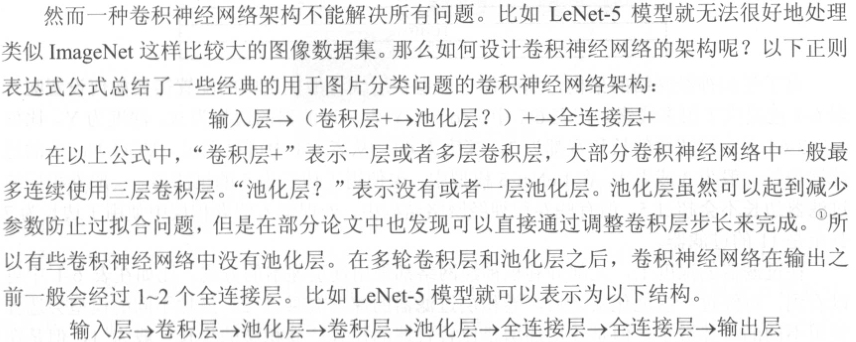

# Inception-v3模型

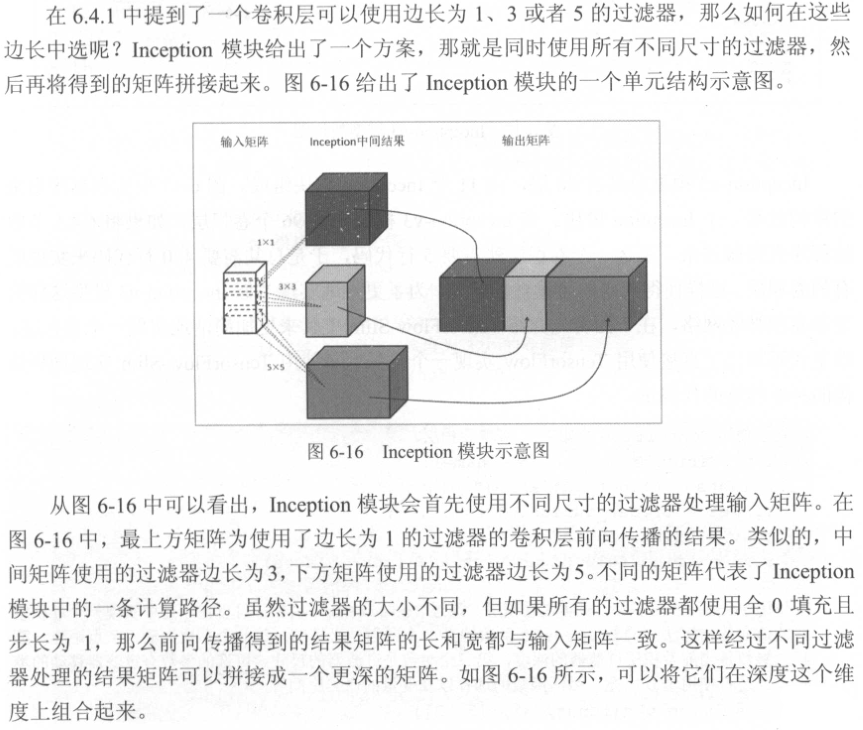

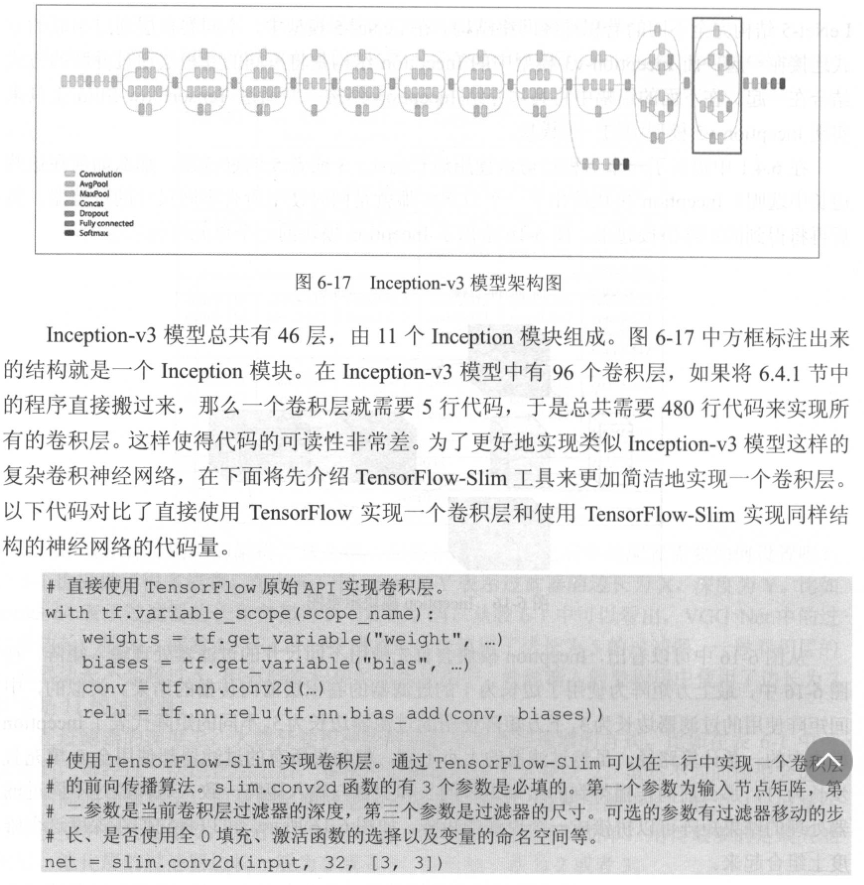

Inception_v3模型源码：https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py

# 卷积神经网络迁移学习

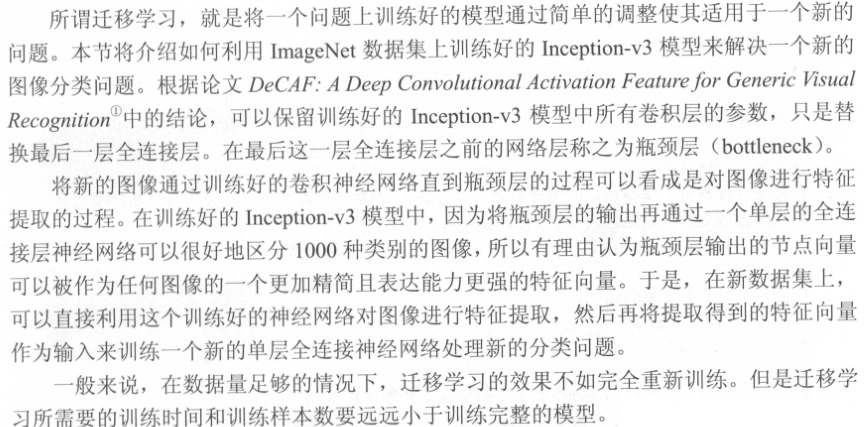

## 内存不足，无法正常运行完成

In [1]:
# -*- coding: utf-8  -*-
import glob
import os.path
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

In [1]:
# 原始输入数据的目录
# 这个目录下有5个子目录，每个目录下保存属于该类别的所有RGB色彩模式的图片
INPUT_DATA = '/opt/jupyter_files/flower_photos'
# 输出文件地址
# 将整理后的图片数据通过numpy的格式保存
OUTPUT_FILE = '/opt/jupyter_files/flower_processed_data.npy'

# 测试数据和验证数据比例
VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

# 读取数据并将数据分割成训练数据、验证数据和测试数据
def create_image_lists(sess, testing_percentage, validation_percentage):
    sub_dirs = [x[0] for x in os.walk(INPUT_DATA)]
    is_root_dir = True
    
    # 初始化各个数据集
    training_images = []
    training_labels = []
    testing_images = []
    testing_labels = []
    validation_images = []
    validation_labels = []
    current_label = 0
    
    # 读取所有的子目录
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue
    
    # 获取一个子目录中所有的图片文件
    extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
    file_list = []
    dir_name = os.path.basename(sub_dir)
    for extension in extensions:
        file_glob = os.path.join(INPUT_DATA, dir_name, '*.' + extension)
        file_list.extend(glob.glob(file_glob))
        if not file_list:
            print('file_list is null')
            continue
        
#         sum = 0
#         print(len(file_list))
        
        # 处理图片数据
        for file_name in file_list:
            
#             sum = sum + 1
            
            # 读取并解析图片
            # 将图片转化为299×299以使inception-v3模型来处理
            image_raw_data = gfile.FastGFile(file_name, 'rb').read()
            image = tf.image.decode_jpeg(image_raw_data)
            if image.dtype != tf.float32:
                image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize_images(image, [299, 299])
            image_value = sess.run(image)
            
            # 随机划分数据集
            chance = np.random.randint(100)
            if chance < validation_percentage:
                validation_images.append(image_value)
                validation_labels.append(current_label)
            elif chance < (testing_percentage + validation_percentage):
                testing_images.append(image_value)
                testing_labels.append(current_label)
            else:
                training_images.append(image_value)
                training_labels.append(current_label)
            
#             print(sum)
        current_label += 1

    # 将训练数据随机打乱以获得更好的训练效果
    state = np.random.get_state()
    np.random.shuffle(training_images)
    np.random.set_state(state)
    np.random.shuffle(training_labels)
    
    return np.asarray([training_images, training_labels,
                      validation_images, validation_labels,
                      testing_images, testing_labels])

# 数据整理主函数
def main():
    with tf.Session() as sess:
        processed_data = create_image_lists(sess,
                                           TEST_PERCENTAGE,
                                           VALIDATION_PERCENTAGE)
        # 通过numpy格式保存处理后的数据
        np.save(OUTPUT_FILE, processed_data)
        
    print('end')
        
if __name__ == '__main__':
    main()

NameError: name 'tf' is not defined

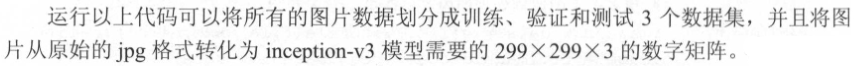
然后下载谷歌提供的训练好的Inception-v3模型。全部准备好之后，就可以完成迁移学习了

In [ ]:
import glob
import os.path
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import tensorflow.contrib.slim as slim

# 加载inception_v3模型
import tensorflow.contrib.slim.python.slim.nets.inception_v3 as inception_v3

# 处理好之后的数据文件
INPUT_DATA = '/opt/jupyter_files/flower_processed_data.npy'
# 保存训练好的模型的路径
# 可以将使用新数据训练得到的完整模型保存下来
# 如果计算资源充足，还可以在训练完最后的全连接层之后再训练所有网络层
# 这样可以使得新模型更加贴近新数据
TRAIN_FILE = '/opt/jupyter_files/model-saves/inception'
# 谷歌提供的训练好的模型文件地址
CKPT_FILE = '/opt/jupyter_files/model-saves/inception/inception_v3.ckpt'

# 定义训练中使用的参数
LEARNING_RATE = 0.0001
STEPS = 300
BATCH = 32
N_CLASSES = 5

# 不需要从谷歌训练好的模型中加载的参数
# 这里就是最后的全连接层，因为在新的问题中要重新训练这一层中的参数
# 这里给出的是参数的前缀
CHECKPOINT_EXCLUDE_SCOPES = 'InceptionV3/Logits,InceptionV3/AuxLogits'
# 需要训练的网络层参数名称，在fine_tuning的过程中就是最后的全连接层
# 这里给出的是参数的前缀
TRAINABLE_SCOPE = 'InceptionV3/Logits,InceptionV3/AuxLogits'

# 获取所有需要从谷歌训练好的模型中加载的参数
def get_tuned_variables():
    exclusions = [scope.strip() for scope in CHECKPOINT_EXCLUDE_SCOPES.split(',')]
    
    variables_to_restore = []
    # 枚举inception-v3模型中所有的参数，然后判断是否需要从加载列表移除
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
    return variables_to_restore

# 获取所有需要训练的变量列表
def get_trainable_variables():
    scopes = [scope.strip() for scope in TRAINABLE_SCOPE.split(',')]
    variables_to_train = []
    # 枚举所有需要训练的参数前缀，并通过这些前缀找到所有的参数
    for scope in scopes:
        variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
        variables_to_train.extend(variables)
    return variables_to_train

def main(argv=None):
    tf.reset_default_graph()
    
    # 加载预处理好的数据
    processed_data = np.load(INPUT_DATA)
    print('processed_data: ', processed_data == null)
    
    training_images = processed_data[0]
    n_training_example = len(training_images)
    training_labels = processed_data[1]
    validation_images = processed_data[2]
    validation_labels = processed_data[3]
    testing_images = processed_data[4]
    testing_labels = processed_data[5]
    print('%d training examples, %d validation examples and %d testing example.' %
         (n_training_example, len(validation_labels), len(testing_labels)))
    
    # 定义inception-v3的输入，images为输入图片，labels为每一张图片对应的标签
    images = tf.placeholder(tf.float32,
                           [None, 299, 299, 3],
                           name='input_images')
    labels = tf.placeholder(tf.int64, [None], name='labels')
    
    # 定义inception-v3模型
    # 因为谷歌给出的只有模型参数取值，所有需要定义inception-v3的模型结构
    # 虽然理论上需要区分训练和测试中使用的模型，也就是在测试时is_training=False
    # 但是预先训练好的inception-v3模型中使用的batch_normalization参数与新数据由差异
    # 导致结果很差，所以直接使用同一个模型来进行测试
    with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
        logits, _ = inception_v3.inception_v3(images, num_classes=N_CLASSES)
    # 获取需要训练的变量
    trainable_variables = get_trainable_variables()
    # 定义交叉熵损失（注意在模型定义时已经将正则化损失加入损失集合了）
    tf.losses.softmax_cross_entropy(tf.one_hot(labels, N_CLASSES),
                                   logits,
                                   weights=1.0)
    # 定义训练过程，这里minimize的过程中指定了需要优化的变量集合
    train_step = tf.train.RMSPropOptimizer(LEARNING_RATE).minimize(tf.losses.get_total_loss())
    
    # 计算正确率
    with tf.name_scope('evaluation'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
        evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 定义加载模型的函数
    load_fn = slim.assign_from_checkpoint_fn(CKPT_FILE,
                                            get_tuned_variables(),
                                            ignore_missing_vars=True)
    
    # 定义保存新的训练好的模型的函数
    saver = tf.train.Saver()
    with tf.Session() as sess:
        # 初始化没有加载进来的变量
        # 注意该过程要在模型加载之前，否则初始化过程会将已经加载好的变量重新赋值
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # 加载谷歌已经训练好的模型
        print('Loading tuned variables from %s' % CKPT_FILE)
        load_fn(sess)
        
        start = 0
        end = BATCH
        for i in range(STEPS):
            # 运行训练过程，这里不会更新全部的参数，只会更新指定的部分参数
            sess.run(train_step,
                    feed_dict={images: training_images[start: end],
                              labels: training_labels[start: end]})
            
            # 输出日志
            if i % 30 == 0 or i + 1 == STEPS:
                saver.save(sess, TRAIN_FILE, global_step=i)
                validation_accuracy = sess.run(evaluation_step,
                                              feed_dict={images: validation_images,
                                                        labels: validation_labels})
                print('Step %d: Validation accuracy = %.lf%%' %
                     (i, validation_accuracy * 100.0))
                
            # 因为在数据预处理的时候已经做过了打乱数据的操作
            # 所以这里只需要顺序使用训练数据就好
            start = end
            if start == n_training_example:
                start = 0
                
            end = start + BATCH
            if end > n_training_example:
                end = n_training_example
                
        # 在最后的测试数据上测试正确率
        test_accuracy = sess.run(evaluation_step,
                                feed_dict={images: testing_images,
                                          labels: testing_labels})
        print('Final test accuracy = %.lf%%' % (test_accuracy * 100))
        
if __name__ == '__main__':
    tf.app.run()